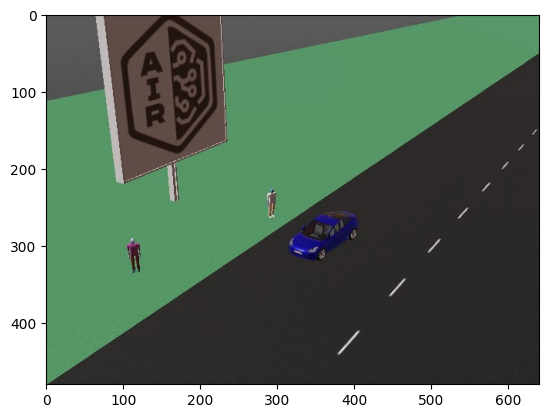

In [2]:
import cv2
import matplotlib.pyplot as plt


image_path = "camera_frame.png"
frame = cv2.imread(image_path)
plt.imshow(frame)


0: 480x640 2 pedestrians, 1 car, 164.5ms
Speed: 0.0ms preprocess, 164.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


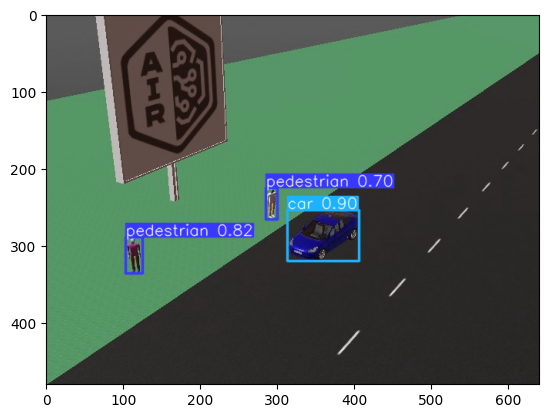

In [14]:
from ultralytics import YOLO


model = YOLO("yolov8n-visdrone.pt")

result = model.predict(
    source=frame,
    imgsz=frame.shape[:2],
    classes=None,
    conf=0.1,
    iou=0.5,
    max_det=10,
    augment=False,
    agnostic_nms=True,
    device="cpu",
    half=False
)[0]

result.save("yolo_visdrone.png")

plt.imshow(result.plot())

In [3]:
import pandas


dataframe = pandas.DataFrame(columns=["x1", "y1", "x2", "y2", "score", "class"])


boxes = result.boxes
detection_number = boxes.shape[0]
for i in range(detection_number):
    class_id = boxes.cls[i].int().item()
    confidence = boxes.conf[i].float().item()
    xyxy = boxes.xyxy[i].int().tolist() 
    
    record = xyxy + [confidence, class_id]
    
    dataframe.loc[i] = record


dataframe

,x1,y1,x2,y2,score,class
0,313.0,254.0,406.0,320.0,0.903729,3.0
1,103.0,289.0,125.0,336.0,0.821215,0.0
2,285.0,225.0,300.0,266.0,0.703146,0.0


In [5]:
import pandas

metrics_dataframe = pandas.read_csv("metrics_dataframe_cuda.csv")

metrics_dataframe

,Model,Layers,Parameters,mP,mR,mAP,mAP50,mAP75,Inference Speed
0,yolov8n-visdrone.pt,168,3007598,0.450921,0.330881,0.196196,0.335294,0.193899,5.728687
1,yolov8s-visdrone.pt,168,11129454,0.520251,0.388662,0.238634,0.399736,0.240570,9.930911
2,yolov8m-visdrone.pt,218,25845550,0.559940,0.427402,0.270577,0.444406,0.276001,14.621206
3,yolov8l-visdrone.pt,268,43614318,0.558780,0.442266,0.280050,0.453957,0.288698,23.338182
4,yolov8x-visdrone.pt,268,68133198,0.566478,0.447070,0.286495,0.461995,0.295569,35.076700


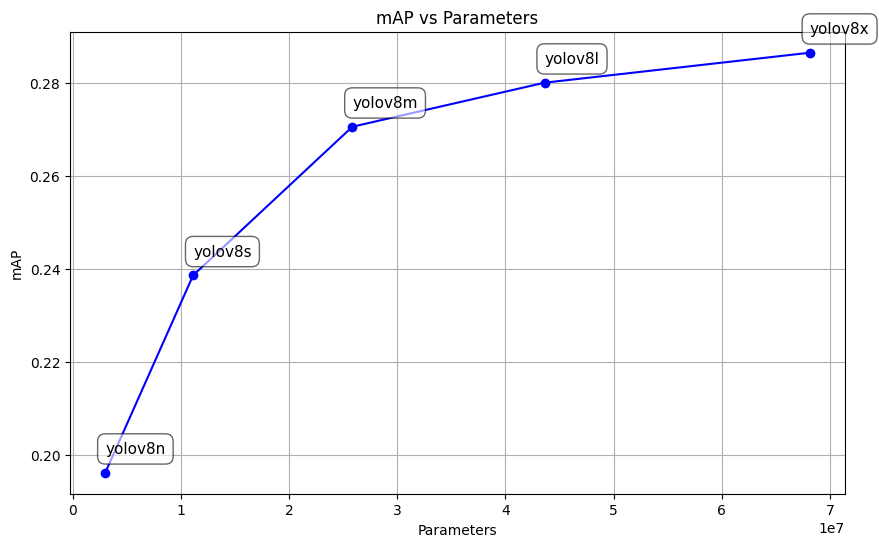

In [6]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(metrics_dataframe["Parameters"], metrics_dataframe["mAP"], marker="o", color="blue", linestyle="-")

offset = 0.0035
for i, point in metrics_dataframe.iterrows():
    plt.text(
        point["Parameters"] + offset, point["mAP"] + offset, 
        point["Model"].split("-")[0],
        fontsize=11,
        ha="left",
        va="bottom",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="black", boxstyle="round, pad=0.5")
    )

plt.title("mAP vs Parameters")
plt.xlabel("Parameters")
plt.ylabel("mAP")
plt.grid(True)
plt.show()

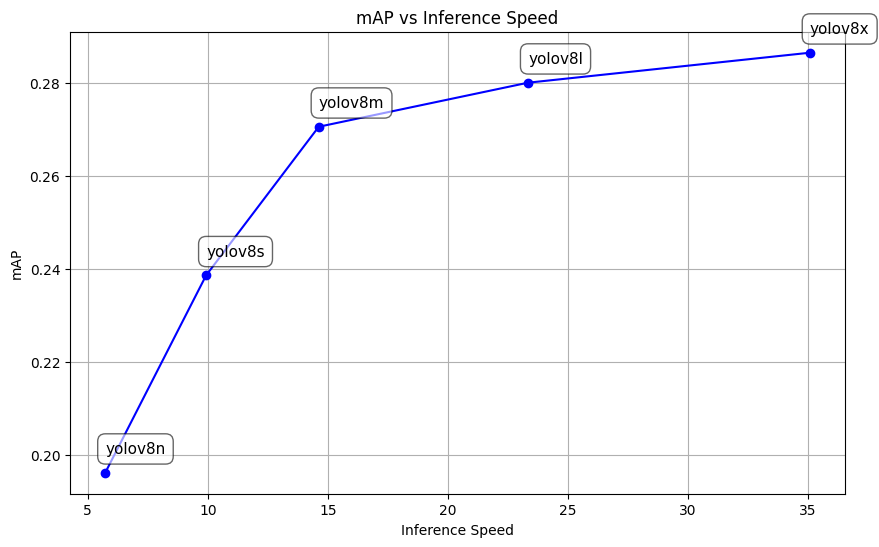

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(metrics_dataframe["Inference Speed"], metrics_dataframe["mAP"], marker="o", color="blue", linestyle="-")

offset = 0.0035
for i, point in metrics_dataframe.iterrows():
    plt.text(
        point["Inference Speed"] + offset, point["mAP"] + offset, 
        point["Model"].split("-")[0],
        fontsize=11,
        ha="left",
        va="bottom",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="black", boxstyle="round, pad=0.5")
    )

plt.title("mAP vs Inference Speed")
plt.xlabel("Inference Speed")
plt.ylabel("mAP")
plt.grid(True)
plt.show()

In [ ]:
from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import DroneData
from data_stream import StreamReceiver
import cv2

host = "192.168.0.107"
port = 5588
stream_receiver = StreamReceiver(host, port)


fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("result.avi", fourcc, 30, (640, 480))

for _ in range(30 * 1):
    data = stream_receiver.get_data()
    drone_data = DroneData.from_json(data)
    camera_frame = drone_data.camera.frame
    
    result = model.predict(
        source=camera_frame,
        imgsz=camera_frame.shape[:2],
        classes=None,
        conf=0.1,
        iou=0.5,
        max_det=10,
        augment=False,
        agnostic_nms=True,
        device="cpu",
        half=False
    )[0]

    detections = []
    boxes = result.boxes
    for i in range(boxes.shape[0]):
        class_id = boxes.cls[i].int().item()
        confidence = boxes.conf[i].float().item()
        xyxy = boxes.xyxy[i].int().tolist()

        record = xyxy + [confidence, class_id]

        detections.append(record)

    plot = result.plot()
    out.write(plot)

out.release()    
